In [1]:
%load_ext autotime

# Flat Frames and System Gain

This notebook will generate a master flat frame for a given camera.

Flat frames should exist in the `panoptes-survey` bucket and are laid out in the following format:

`<UNITID>/calibration/flats/<CAMID>/<DATESTAMP>/flat_<NUM>.fits.fz`

e.g.

`PAN001/calibration/flats/ee04d1/20180725T052258/flat_00.fits.fz`

In [2]:
import os
import numpy as np

from astropy.io import fits
from astropy.stats import sigma_clipped_stats #, sigma_clip
from astropy.nddata import Cutout2D

from matplotlib import pyplot as plt
from matplotlib.backends.backend_agg import FigureCanvasAgg as FigureCanvas
from matplotlib.figure import Figure
from mpl_toolkits.axes_grid1 import make_axes_locatable
plt.style.use('bmh')

from scipy import fftpack
from matplotlib.colors import LogNorm

from scipy.stats import linregress
import pandas as pd

from tqdm import tqdm_notebook

from piaa.utils import helpers
from pocs.utils.google import storage
from pocs.utils.images import fits as fits_utils

from IPython.display import display, Image

time: 7.68 s


In [3]:
pan_store = storage.PanStorage('panoptes-survey')

time: 195 ms


In [4]:
unit_id = 'PAN001'
camera_id = '14d3bd'

time: 2.71 ms


## Flat Fields

### Gather images

We gather the images from the storage bucket. We only search for those flat images which match our `unit_id` and `camera_id`. These files are downloaded locally.

In [5]:
# Get our calibration images for the unit
calibration_images = pan_store.get_file_blobs(f'{unit_id}/calibration/flats/{camera_id}', filter_ext='.fz')

# Save FITS files to this location
local_save_dir = '/var/panoptes/images/flats'
os.makedirs(local_save_dir, exist_ok=True)

time: 154 ms


In [6]:
# !!!WARNING - Download from the google storage buckets - lots of data - WARNING!!!
# This will check for existing files so is safe to run twice without wait on second time.
file_list = list()
for fn in tqdm_notebook(calibration_images):
    local_fn = pan_store.download_file(fn, save_dir=local_save_dir)
    file_list.append(local_fn)

# Get the local path names
flat_files = [fn for fn in file_list if 'flats_{}'.format(camera_id) in fn]
print(f"Total flat file count for camera {camera_id}: {len(flat_files)}")

TypeError: request() got an unexpected keyword argument 'data'

time: 507 ms


Gather the mask data for the color filter array. We use a helper fuction that gathers the data and the masks directly from the first image.

In [7]:
r_data, g_data, b_data = helpers.get_rgb_data(fits.getdata(flat_files[0]))
r_mask = r_data.mask
g_mask = g_data.mask
b_mask = b_data.mask

time: 48.1 s


### Find good flats

We want to use flats that are filling up the well about half-way. Here we set a mininum and maxium level and aim for the half-way point between those two. 

We also define some parameters for the number of allowable saturated pixels as well as whether or not we have enough counts within target.

In [8]:
bias = 2048
min_level = 1000
saturation_level = 11500  # (bias removed)
desired_percentage = 0.5

enough_counts_fractional_error = 0.0125
fraction_saturated_pixels_limit = 0.05

center_position = (int(3476/2), int(5208/2))

desired_count = (saturation_level + min_level) * desired_percentage
print("Desired count: ", desired_count)

Desired count:  6250.0
time: 1.53 ms


In [9]:
def inv_median_center(data, stats_region=0.3, xaxis_number=1, yaxis_number=0):
    """
    Compute 1/median for scaling the flat field data using only a limited central region
    specified by stats_region parameter.
    """

    try:
        h = data.shape[0]
        w = data.shape[1]
    except IndexError:
        h = w = int(np.sqrt(data.shape[0]))
        data = data.reshape(h, w)
        
    center_xy = (int(h/2), int(w/2))
    size = (w*stats_region, h*stats_region)
    
    d0 = Cutout2D(data, center_xy, size)

    return 1. / np.median(d0.data)

time: 10.9 ms


In [10]:
flat_data = None

num_flats = 0

master_flat_data = list()
master_flat_weights = list()
flat_fn = list()
exp_times = list()

good_flats = list()

for f in flat_files:
    
    try:
        header = fits_utils.getheader(f)
    except Exception as e:
        print(f, e)
        continue

    data = fits.getdata(f)
    
    exp_time = float(header['EXPTIME'])
    # Skip flats under 3 seconds (kind of empirical)
    if exp_time < 3:
        continue            

    # Get data and remove bias
    d0 = data - bias

    # Get center region
    c0 = Cutout2D(d0, center_position, 1000)

    mean, median, std = sigma_clipped_stats(c0.data)

    median_counts = np.median(c0.data)
    frac_saturated = np.sum(c0.data >= saturation_level) / (c0.data.shape[1] * c0.data.shape[0])

    # Figure out if within acceptables counts
    if (np.sqrt(median_counts) / median_counts < enough_counts_fractional_error 
        and frac_saturated < fraction_saturated_pixels_limit):

        flat_fn.append(f)
        exp_times.append(exp_time)

        print("Using Flat: {:5.02f}s μ={:.02f} σ={:.02f} Median={} FEC={:.02%} Sat: {:.0%}".format(
            exp_time, 
            mean, 
            std, 
            median, 
            np.sqrt(median_counts) / median_counts,
            frac_saturated
        ))

        g_data = np.ma.array(d0, mask=~g_mask)
        master_flat_weights.append(inv_median_center(g_data))
        master_flat_data.append(d0)
        good_flats.append(f)
        
"Good flats: {}".format(len(master_flat_data))        

Using Flat:  3.90s μ=6289.16 σ=2710.15 Median=7137.0 FEC=1.18% Sat: 0%


/home/wtylergee/miniconda3/envs/pipeline/lib/python3.6/site-packages/numpy/core/fromnumeric.py:688: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedArray.
  a.partition(kth, axis=axis, kind=kind, order=order)


Using Flat:  4.90s μ=6378.79 σ=2755.74 Median=7233.0 FEC=1.18% Sat: 0%
Using Flat:  5.90s μ=6165.67 σ=2670.32 Median=6988.0 FEC=1.20% Sat: 0%
Using Flat:  8.90s μ=6211.23 σ=2702.51 Median=7029.0 FEC=1.19% Sat: 0%
Using Flat: 10.90s μ=5979.84 σ=2610.34 Median=6760.0 FEC=1.22% Sat: 0%
Using Flat: 13.90s μ=5962.74 σ=2611.08 Median=6732.0 FEC=1.22% Sat: 0%
Using Flat: 17.90s μ=5953.41 σ=2614.54 Median=6714.0 FEC=1.22% Sat: 0%
Using Flat: 23.90s μ=6095.22 σ=2685.11 Median=6864.0 FEC=1.21% Sat: 0%
Using Flat: 31.90s μ=6128.25 σ=2709.63 Median=6888.0 FEC=1.20% Sat: 0%
Using Flat: 42.90s μ=6095.82 σ=2706.34 Median=6839.0 FEC=1.21% Sat: 0%


'Good flats: 10'

time: 13.4 s


In [35]:
good_flats = sorted(good_flats)

time: 664 µs


In [36]:
best = list()

d0 = fits.getdata(good_flats[0]).astype(np.float) - bias

slice0 = helpers.get_stamp_slice(center_position[0], center_position[1], stamp_size=(1002, 1002))
c0 = d0[slice0]
# c0 = Cutout2D(d0, center_position, cutout_size)
r0, g0, b0 = helpers.get_rgb_data(c0, force_new=True)

for i, fn in enumerate(good_flats[1:]):
    d1 = (fits.getdata(fn).astype(np.float) - bias)
    c1 = d1[slice0] + 5000
#     c1 = Cutout2D(d1, center_position, cutout_size)
    r1, g1, b1 = helpers.get_rgb_data(c1, force_new=True)
    
    best.append([i, 'r', r1.mean() * 2, (r1 - r0).var()])
    best.append([i, 'g', g1.mean() * 2, (g1 - g0).var()])
    best.append([i, 'b', b1.mean() * 2, (b1 - b0).var()])

time: 31.7 s


In [31]:
flat_data = pd.DataFrame(best, columns=['frame', 'color', 'm', 'v']).set_index(['frame'])

color_groups = flat_data.groupby('color')

time: 4.73 ms


In [32]:
flat_data.head()

,color,m,v
frame,,,
0,r,13705.393787,2046.019769
0,g,24564.807590,7687.003757
0,b,28476.245774,9060.298030
1,r,13565.284329,2442.499757
1,g,24069.824146,8252.905675


time: 21.9 ms


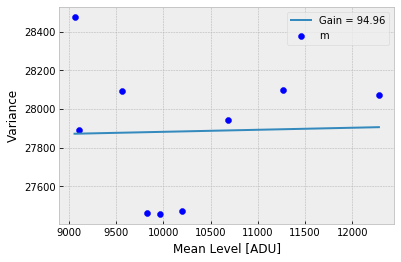

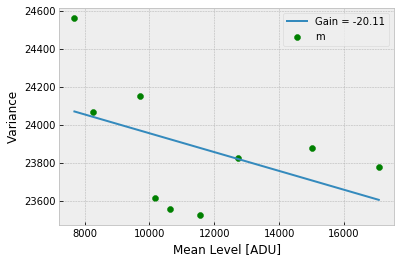

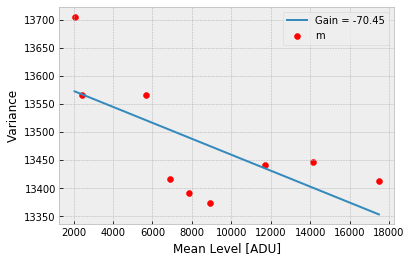

time: 1.08 s


In [33]:
for color, grp in color_groups:
    plt.figure()
    x = grp['v']
    y = grp['m']
    plt.scatter(x, y, color=color)
    slope, intercept, r_value, p_value, std_err = linregress(x,y)
    
    x_range = np.linspace(x.min(), x.max())
    y2 = (slope * x_range) + intercept
    plt.plot(x_range, y2, label=f'Gain = {1/slope:.02f}')
    
    plt.xlabel('Mean Level [ADU]')
    plt.ylabel('Variance')
    plt.legend()

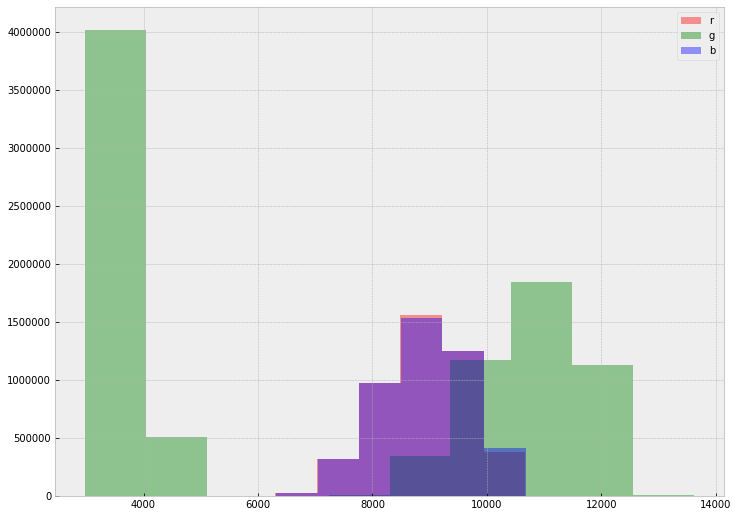

time: 1.2 s


In [48]:
plt.figure(figsize=(12, 9))
plt.hist(r0.compressed(), alpha=0.4, color='r', label='r')
plt.hist(g0.compressed(), alpha=0.4, color='g', label='g')
plt.hist(b0.compressed(), alpha=0.4, color='b', label='b')
plt.legend()

#### Save or Load Flats Files

In [11]:
# File name to hold compressed numpy arrays for flat files
flat_data_file = '/var/panoptes/images/{}-{}-master_flat_data.npz'.format(unit_id, camera_id)

time: 746 µs


In [12]:
# Save the file
np.savez_compressed(flat_data_file, *master_flat_data)

time: 43.1 s


In [14]:
# Or load the file
flat_files_npz = np.load(flat_data_file)

flat_file_data = np.array([flat_files_npz[f].astype(np.float32) for f in flat_files_npz.files])

time: 12.2 s


### Create Master Flat

Do a median combine of the flats to create one master flat for the camera and save as a FITS file

In [14]:
flat_fits = '/var/panoptes/images/{}-{}-master-flat.fits'.format(unit_id, camera_id)

# Combine all the flats
master_flat = np.median(master_flat_data, axis=0)

hdu = fits.PrimaryHDU(master_flat.astype(np.float32))
hdul = fits.HDUList([hdu])
hdul.writeto(flat_fits, overwrite=True)

time: 2.85 s


## System Gain (simple)

Do a simple gain check. This can be computed as:

$$\textrm{gain} = \frac{\textrm{mean} (f0 + f1)}{\textrm{variance} (f0 - f1)}$$

In [15]:
f0 = flat_file_data[0].astype(np.float)
f1 = flat_file_data[1].astype(np.float)

flat_mean = (f0 + f1).mean()
flat_vary = (f0 - f1).var()
gain = flat_mean / flat_vary

print("Gain is {:.02f} e-/ADU".format(gain))

Gain is 1.49 e-/ADU
time: 570 ms


In [16]:
from matplotlib import pyplot as plt

time: 933 µs


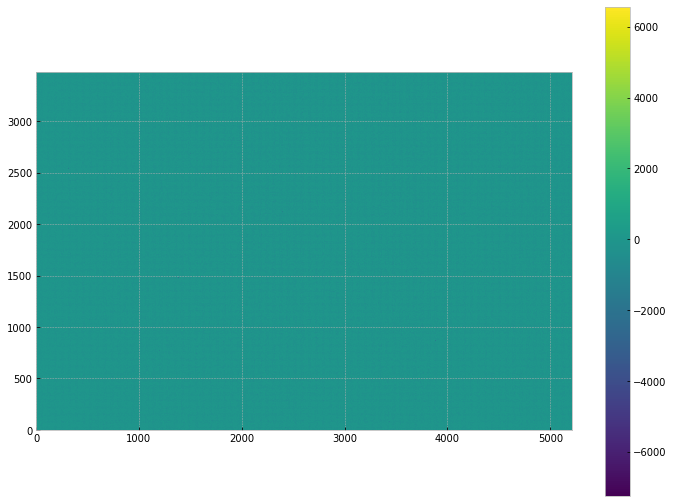

time: 2.11 s


In [23]:
plt.figure(figsize=(12, 9))
plt.imshow(f0 - f1, origin='lower')
plt.colorbar()

### Examine Master Flat

In [16]:
# Load the master flat
master_flat = fits.getdata('/var/panoptes/images/{}-{}-master-flat.fits'.format(unit_id, camera_id))

time: 10.1 ms


In [17]:
r_data, g_data, b_data = helpers.get_rgb_data(master_flat)

time: 606 ms


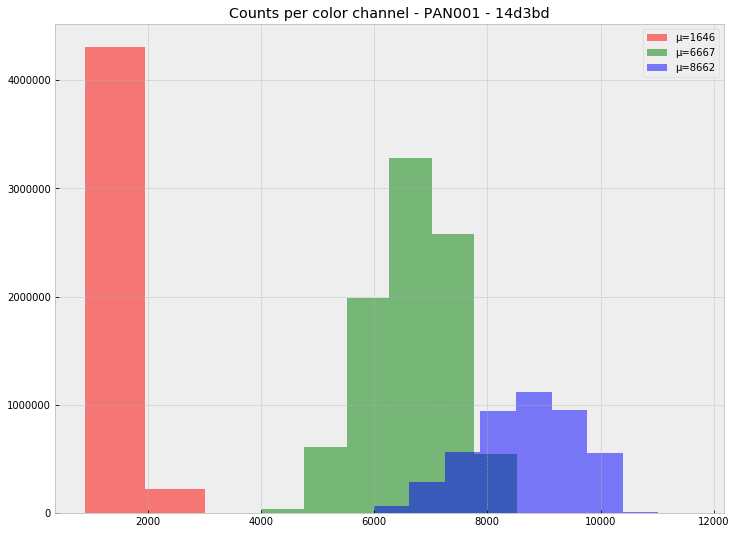

time: 1.83 s


In [21]:
plt.figure(figsize=(12, 9))
hist = plt.hist(r_data.compressed(), color='r', alpha=0.5, label=f'μ={r_data.mean():.0f}')
hist = plt.hist(g_data.compressed(), color='g', alpha=0.5, label=f'μ={g_data.mean():.0f}')
hist = plt.hist(b_data.compressed(), color='b', alpha=0.5, label=f'μ={b_data.mean():.0f}')

plt.title(f'Counts per color channel - {unit_id} - {camera_id}')

plt.legend()
plt.savefig('flat-hist-colors.png', dpi=150, transparent=False)

#### Master flat structure

Show the FFT of the master flat to look for any structure.

In [19]:
fig = Figure()
fft_fig = Figure()
FigureCanvas(fig)
FigureCanvas(fft_fig)

ax = fig.add_subplot(111)
ax2 = fft_fig.add_subplot(111)

# Show the flat
im = ax.imshow(master_flat, cmap='Greys', norm=LogNorm())
ax.set_title('Master Flat')

# Colorbar
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.05)
fig.colorbar(im, cax=cax)

# FFT
f0 = fftpack.fft2(master_flat.astype(np.float))
ax2.imshow(np.abs(f0), cmap='Greys', norm=LogNorm(vmin=5))
ax2.set_title('Master Flat FFT')

ax.set_xticklabels([])
ax.set_yticklabels([])
ax2.set_xticklabels([])
ax2.set_yticklabels([])

fig.tight_layout()
fig.set_size_inches(fig.get_size_inches() * 2)
fig.savefig('/var/panoptes/images/pan001-{}-master-flat-01.png'.format(camera_id), transparent=False)

fft_fig.tight_layout()
fft_fig.set_size_inches(fig.get_size_inches() * 2)
fft_fig.savefig('/var/panoptes/images/pan001-{}-master-flat-01-fft.png'.format(camera_id), transparent=False)

/home/wtylergee/miniconda3/lib/python3.6/site-packages/scipy/fftpack/basic.py:160: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  z[index] = x


time: 5.39 s


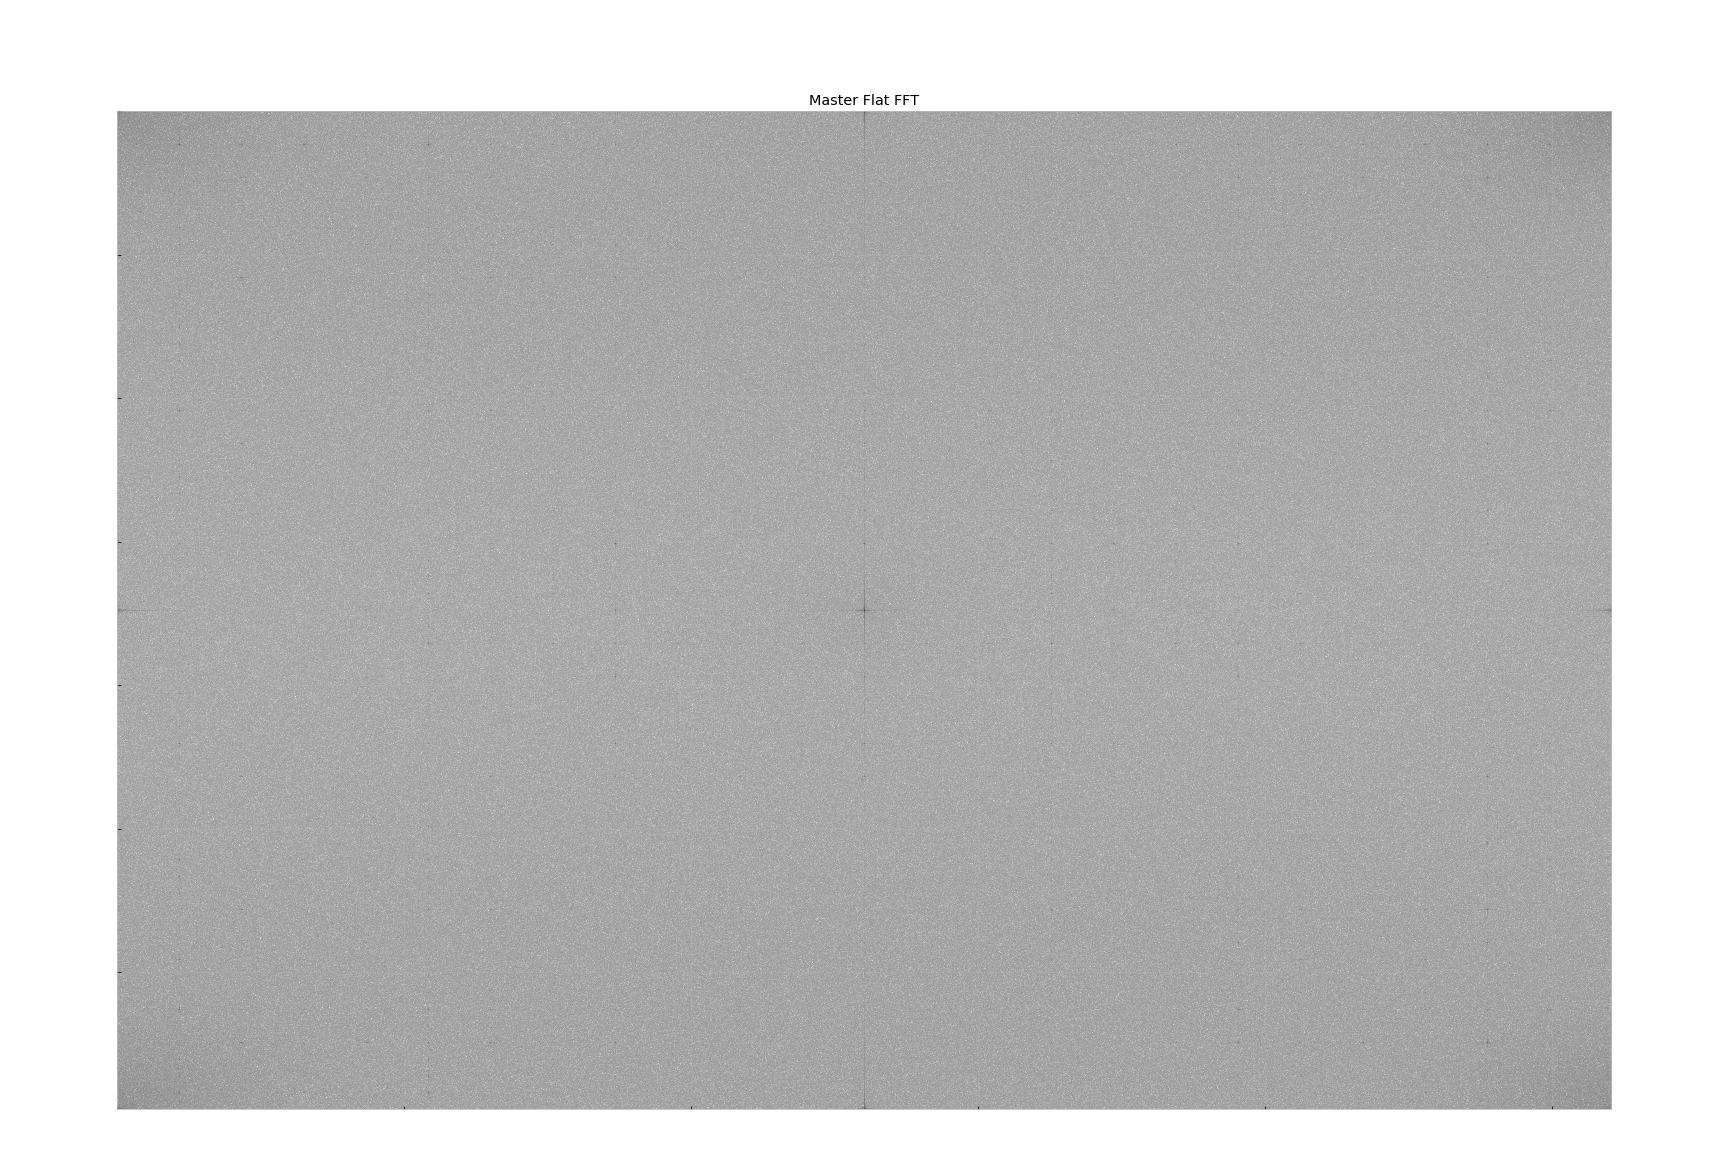

time: 39.4 ms


In [20]:
Image(filename='/var/panoptes/images/pan001-{}-master-flat-01-fft.png'.format(camera_id))